Author: William Wyatt

Purpose: To run LLMs against eachother in a stag-hare game to resolve how they compare to human trials and understand their reasoning.

In [2]:
# Imports
from openai import OpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import List, Optional, Dict
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np
import yaml, json
import pandas as pd
import os, time, random
from multiprocessing import Pool

load_dotenv() #Load in a .env file with the variable OPENAI_API_KEY set to your OpenAI API key
client = OpenAI()

# Constants
TRIALS = 20
ROUNDS = 15
SAVE=False
MODEL = "gpt-4o-mini"
REVEAL_REASONING = False
PROMPT_SYSTEM_PATH = './prompts/system_prompt_2.txt'
PROMPT_PAIR_PATH = './prompts/play_for_pair_4_1.txt'
PROMPT_SELF_PATH = './prompts/play_for_self_4_1.txt'
RANDOM_AGENT=False
PERSONA=None

# Setup
Below we setup personas along with the enums used by ChatGPT to get the results. 

In [3]:
# Personas
with open('./personas.json') as f:
    personas = json.load(f)
# ["none","young_person","older_person","man","woman","competitive_person","introvert","extrovert"]   
PERSONA_NAME = None
PERSONA = None
#PERSONA = personas[PERSONA_NAME]
print(PERSONA)

None


In [4]:
class GameEvent(BaseModel):
    stag: bool
    reasoning: str

class History(BaseModel):
    name: str
    stag: bool
    period: int
    payoff: int
    reasoning: str

class Games(BaseModel):
    event: List[GameEvent] = Field(default_factory=list)

class GameHistory(BaseModel):
    history: List[History] = Field(default_factory=list)

def run_agent_decision(system_prompt, game_prompt, name=None, model=MODEL, response_format=GameEvent):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": game_prompt}
    ]
    try:
        response = client.beta.chat.completions.parse(
            model=model, 
            messages=messages,
            response_format=response_format
            )
        results = response_format.model_validate_json(response.choices[0].message.content).model_dump()
        #print(f"{name} ({results['stag']}): {results['reasoning']}")
        results['name'] = name
        results['model'] = model
        return results
    except Exception as e:
        raise e


In [5]:
# Random Agent - p=50% Bernoulli
def get_random_decision():
    choice = {"stag": random.choice([True, False]), "reasoning": "random"}
    #print(f"Chose {choice['option_a']} randomly")
    return choice

In [6]:
# Random Agent - p=87.5% Bernoulli
def get_mixed_strat():
    rng = random.random()
    if rng < 7/8:
        choice = {"stag": True, "reasoning": "mixed"}
    else:
        choice = {"stag": False, "reasoning": "mixed"}
    #print(f"Chose {choice['stag']} randomly")
    return choice

# Game Details
This the bulk of the code. Describing the game functionality. Running a sessions with rounds, a repeated game. Along with the logic for the LLMs to play the game. 

In [7]:
# Sets game parameters
PAYOFF_HIGH = 9
PAYOFF_MID  = 8
PAYOFF_LOW  = 1

# Gets prompts
PROMPT_SYSTEM = open(PROMPT_SYSTEM_PATH,'r').read()

# Sets personas into system prompt
if PERSONA is not None:
    PROMPT_SYSTEM = PROMPT_SYSTEM.replace("PERSONA",PERSONA)
    print(PROMPT_SYSTEM)

# Get user prompts
PROMPT_PAIR = open(PROMPT_PAIR_PATH,'r').read()
PROMPT_SELF = open(PROMPT_SELF_PATH,'r').read()

# Run Game
def calculate_payoff(round_events):
    payoffs = {}
    name_1,name_2 = list(round_events.keys())
    decision_1 = round_events[name_1]['stag']
    decision_2 = round_events[name_2]['stag']
    if decision_1 and decision_2:
        payoffs[name_1] = PAYOFF_HIGH
        payoffs[name_2] = PAYOFF_HIGH
    elif decision_1 and not decision_2:
        payoffs[name_1] = PAYOFF_LOW
        payoffs[name_2] = PAYOFF_MID
    elif not decision_1 and decision_2:
        payoffs[name_1] = PAYOFF_MID
        payoffs[name_2] = PAYOFF_LOW
    else:
        payoffs[name_1] = PAYOFF_MID
        payoffs[name_2] = PAYOFF_MID
    return payoffs

# Summarize game results into a string to give back to the LLM agent's user prompt
def get_game_summary(name, histories, reveal_reasoning=REVEAL_REASONING):
    if len(histories) == 0:
        return ""
    summary = "# Previous Game Summaries\n"
    for round, round_events in enumerate(histories):
        summary += f"## Round {round}\n"
        for _, event in round_events.items():
            _name = "You" if event.name == name else event.name
            _reasoning = event.reasoning
            _selection = "Stag" if event.stag else "Hare"
            summary += f"- {_name} selected {_selection} and received a payoff of {event.payoff}\n"
            if reveal_reasoning and event.name == name:
                summary += f"  - Your Reasoning: {_reasoning}\n"
        summary += "\n"
    print(summary)
    return summary

# Run a number of rounds of the game, in one entire session.
# - rounds: number of rounds to play
# - player_names: list of player names
# - system_prompt: the system prompt to use
# - prompt: the user prompt to use
# - strat: Is not None will use a custom strategy instead of LLM vs LLM
def run_session(rounds, player_names, system_prompt, prompt, strat=None):
    histories = []
    for round in range(rounds):
        round_events = {}
        decisions = {}
        for i,name in enumerate(player_names):
            game_summary = get_game_summary(name, histories)
            #print(prompt + game_summary)
            if strat is not None and i > 0:
                decisions[name] = strat()
            else:
                decisions[name] = run_agent_decision(system_prompt, prompt + game_summary, name)
        
        payoffs = calculate_payoff(decisions)
        
        for name, decision_result in decisions.items():
            event = History(name=name, stag=decision_result['stag'], period=round, payoff=payoffs[name], reasoning=decision_result['reasoning'])
            round_events[name] = event
            
        histories.append(round_events)
    return histories

# Returns a dataframe given a list of histories enums
def get_df_from_history(all_histories):
    data = []
    print(all_histories)
    for round, histories in enumerate(all_histories):
        for name,history in histories.items():
            data.append({
                'player': name,
                'period': history.period,
                'stag': history.stag,
                'payoff': history.payoff
            })
    return pd.DataFrame(data)

# Wrapper function for the play for pair game
# - return_df: If True returns a dataframe, otherwise returns the list of History Objects
def run_session_play_for_pair(rounds=15, strat=None, return_df=True):
    if RANDOM_AGENT == True:
        strat = get_random_decision
    player_names = ['Team1','Team2']
    system_prompt = PROMPT_SYSTEM
    prompt = PROMPT_PAIR
    
    all_histories = run_session(rounds, player_names, system_prompt, prompt, strat)
    
    if return_df:
        return get_df_from_history(all_histories)
    else:
        return all_histories

# Wrapper function for the play for self game
# - return_df: If True returns a dataframe, otherwise returns the list of History Objects        
def run_session_play_for_self(rounds=15, strat=None, return_df=True):
    if RANDOM_AGENT == True:
        strat = get_random_decision
    player_names = ['Player1', 'Player2']
    system_prompt = PROMPT_SYSTEM
    prompt = PROMPT_SELF
    
    all_histories = run_session(rounds, player_names, system_prompt, prompt, strat)
    if return_df:
        return get_df_from_history(all_histories)
    else:
        return all_histories

# Testing
The following code blocks are used for a brief test of the LLMs.

Additionally, this section is where new functions can be sandboxed. 

In [8]:
# Run one game just to test the code is working
pp_test = run_session_play_for_pair(1, return_df=False)
ps_test = run_session_play_for_self(1, return_df=False)

In [9]:
# Extra function to ask the LLM about its actions.
def get_conclusion(histories):
    query = "You are Team 1. Why did you choose this original decision despite it being more risky? Even though you were responsible for another person? Please provide 500 words."
    
    summary = get_game_summary("Team1", histories, reveal_reasoning=True)
    messages = [
        {"role": "system", "content": PROMPT_SYSTEM},
        {"role": "assistant", "content": PROMPT_PAIR +summary},
        {"role": "user", "content": query}
]
    response = client.chat.completions.create(
        model=MODEL, 
        messages=messages,
    )
    return response.choices[0].message.content
##print(get_conclusion(pp_test))

# Running the Game
The following blocks of code will run the simulation.

In [10]:
# Multithreadding to run play for pair games
with Pool(20) as p:
    results_pair = p.map(run_session_play_for_pair, [ROUNDS]*TRIALS)
pp_df = pd.concat(results_pair)
print(pp_df['stag'].mean())
pp_df

# Previous Game Summaries
## Round 0
- You selected Hare and received a payoff of 8
- Team2 selected Stag and received a payoff of 1


# Previous Game Summaries
## Round 0
- You selected Stag and received a payoff of 9
- Team2 selected Stag and received a payoff of 9

# Previous Game Summaries
## Round 0
- You selected Hare and received a payoff of 8
- Team2 selected Hare and received a payoff of 8



# Previous Game Summaries
## Round 0
- You selected Stag and received a payoff of 1
- Team2 selected Hare and received a payoff of 8


# Previous Game Summaries
## Round 0
- You selected Hare and received a payoff of 8
- Team2 selected Hare and received a payoff of 8

# Previous Game Summaries
## Round 0
- You selected Hare and received a payoff of 8
- Team2 selected Stag and received a payoff of 1



# Previous Game Summaries
## Round 0
- You selected Stag and received a payoff of 1
- Team2 selected Hare and received a payoff of 8

# Previous Game Summaries
## Round 0
- You selected Stag

,player,period,stag,payoff
0,Team1,0,True,9
1,Team2,0,True,9
2,Team1,1,True,1
3,Team2,1,False,8
4,Team1,2,False,8
...,...,...,...,...
25,Team2,12,True,9
26,Team1,13,True,9
27,Team2,13,True,9
28,Team1,14,True,9


In [11]:
# Mutlithreadding to run play for self games
with Pool(20) as p:
    results_self = p.map(run_session_play_for_self, [ROUNDS]*TRIALS)
ps_df = pd.concat(results_self)
print(ps_df['stag'].mean())
ps_df

# Previous Game Summaries
## Round 0
- You selected Stag and received a payoff of 9
- Player2 selected Stag and received a payoff of 9

# Previous Game Summaries
## Round 0
- You selected Hare and received a payoff of 8
- Player2 selected Stag and received a payoff of 1



# Previous Game Summaries
## Round 0
- You selected Stag and received a payoff of 1
- Player2 selected Hare and received a payoff of 8


# Previous Game Summaries
## Round 0
- You selected Hare and received a payoff of 8
- Player2 selected Stag and received a payoff of 1


# Previous Game Summaries
## Round 0
- You selected Stag and received a payoff of 9
- Player2 selected Stag and received a payoff of 9


# Previous Game Summaries
## Round 0
- You selected Stag and received a payoff of 9
- Player2 selected Stag and received a payoff of 9


# Previous Game Summaries
## Round 0
- You selected Stag and received a payoff of 9
- Player2 selected Stag and received a payoff of 9

# Previous Game Summaries
## Round 0
- You

,player,period,stag,payoff
0,Player1,0,True,9
1,Player2,0,True,9
2,Player1,1,True,9
3,Player2,1,True,9
4,Player1,2,True,9
...,...,...,...,...
25,Player2,12,False,8
26,Player1,13,False,8
27,Player2,13,False,8
28,Player1,14,False,8


# Saving
Save the game data and the metadata.

In [12]:
# Save the metadata of the game and the data resulted from the games to file. 

timestamp = int(time.time())

persona_ids = {
  "none": 1734395183,
  "young_person": 1738885303,
  "older_person": 1738885546,
  "man": 1738885722,
  "woman": 1738885914,
  "competitive_person": 1738886203,
  "introvert": 1738886397,
  "extrovert": 1738886580
}

if PERSONA_NAME in persona_ids:
    persona_id = persona_ids[PERSONA_NAME]
    timestamp = persona_id
    _pp_df = pd.read_csv(f"dist/pp_df_{persona_id}.csv")
    _ps_df = pd.read_csv(f"dist/ps_df_{persona_id}.csv")
    print(f"Current {len(pp_df)}, previous {len(_pp_df)}")
    pp_df = pd.concat([_pp_df, pp_df])
    ps_df = pd.concat([_ps_df, ps_df])
    print(f"Now {len(pp_df)}")

if SAVE or TRIALS > 10:

    path_info = {
        'system path': PROMPT_SYSTEM_PATH,
        'pair path': PROMPT_PAIR_PATH,
        'self path': PROMPT_SELF_PATH
    }
    metadata = {
        'time': timestamp,
        'SAVE': SAVE,
        'REVEAL_REASONING': REVEAL_REASONING,
        'PERSONA': PERSONA,
        'number of rounds': TRIALS,
        'rounds per trail': ROUNDS,
        'number ow rows': len(pp_df),
        'random agent': RANDOM_AGENT,
        'model used': MODEL,
        'game model': vars(GameEvent)['__annotations__'],
        'path_info': path_info,
        'prompts':
        {
            'system': PROMPT_SYSTEM,
            'pair': PROMPT_PAIR,
            'self': PROMPT_SELF
        }
        
    }
    filename = f'./dist/notes_{int(timestamp)}.yaml'

    # Write metadata in yaml format
    with open(filename, 'w') as file:
        documents = yaml.dump(metadata, file)
    
    
    pp_df.to_csv(f'./dist/pp_df_{int(timestamp)}.csv', index=False)
    ps_df.to_csv(f'./dist/ps_df_{int(timestamp)}.csv', index=False)
print(int(timestamp))

1745975387


In [13]:
pp_df = pd.read_csv(f'./dist/pp_df_{int(timestamp)}.csv')
ps_df = pd.read_csv(f'./dist/ps_df_{int(timestamp)}.csv')
print(len(pp_df), len(ps_df))

600 600


# Analysis
A quick analysis of the aggregate choices. 

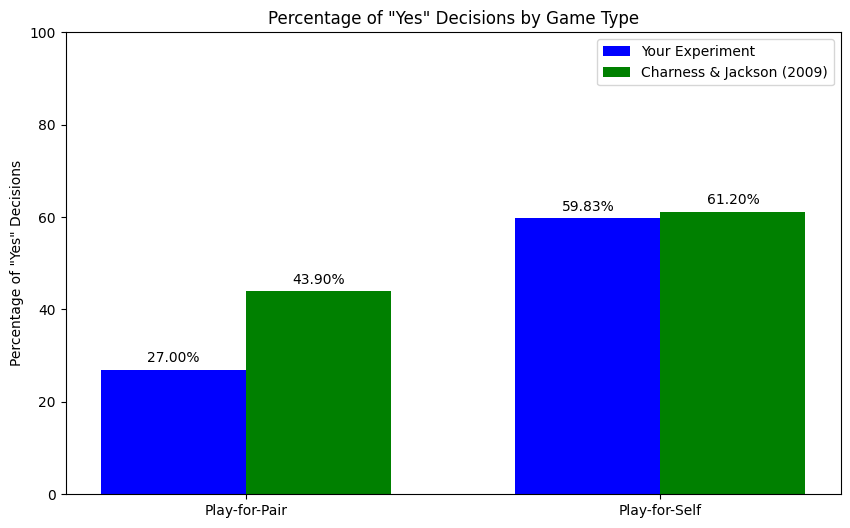

In [14]:
## Percentages

# Play-for-Pair
pp_total_decisions = len(pp_df)
pp_yes_decisions = pp_df[pp_df['stag'] == True].shape[0]
pp_percentage_yes = (pp_yes_decisions / pp_total_decisions) * 100

# Play-for-Self
ps_total_decisions = len(ps_df)
ps_yes_decisions = ps_df[ps_df['stag'] == True].shape[0]
ps_percentage_yes = (ps_yes_decisions / ps_total_decisions) * 100

# Your experiment's percentages
your_percentages = [pp_percentage_yes, ps_percentage_yes]

# Papers Results
paper_pp_percentage = 43.9
paper_ps_percentage = 61.2

paper_percentages = [paper_pp_percentage, paper_ps_percentage]

# Data for plotting
game_types = ['Play-for-Pair', 'Play-for-Self']
x = np.arange(len(game_types))  # the label locations
width = 0.35  # the width of the bars

# Create the bar chart
plt.figure(figsize=(10, 6))
rects1 = plt.bar(x - width/2, your_percentages, width, label='Your Experiment', color=['blue'])
rects2 = plt.bar(x + width/2, paper_percentages, width, label='Charness & Jackson (2009)', color=['green'])

# Add percentage labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.2f}%',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Chart formatting
plt.title('Percentage of "Yes" Decisions by Game Type')
plt.ylabel('Percentage of "Yes" Decisions')
plt.xticks(x, game_types)
plt.ylim(0, 100)
plt.legend()

plt.show()


In [15]:
pp_df

,player,period,stag,payoff
0,Team1,0,True,9
1,Team2,0,True,9
2,Team1,1,True,1
3,Team2,1,False,8
4,Team1,2,False,8
...,...,...,...,...
595,Team2,12,True,9
596,Team1,13,True,9
597,Team2,13,True,9
598,Team1,14,True,9


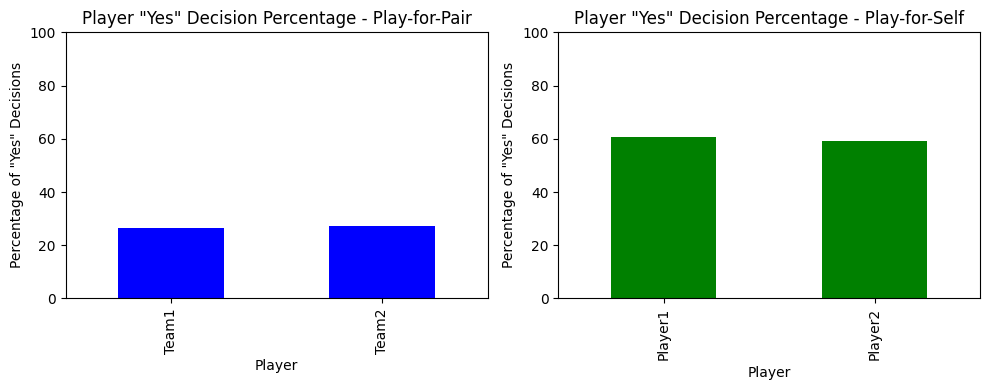

In [16]:
# Calculate percentage of "Yes" decisions per player for Play-for-Pair
pp_player_percentages = pp_df.groupby('player')['stag'].mean() * 100

# Calculate percentage of "Yes" decisions per player for Play-for-Self
ps_player_percentages = ps_df.groupby('player')['stag'].mean() * 100

# Plotting for Play-for-Pair
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
pp_player_percentages.plot(kind='bar', color='blue')
plt.title('Player "Yes" Decision Percentage - Play-for-Pair')
plt.xlabel('Player')
plt.ylabel('Percentage of "Yes" Decisions')
plt.ylim(0, 100)

# Plotting for Play-for-Self
plt.subplot(1, 2, 2)
ps_player_percentages.plot(kind='bar', color='green')
plt.title('Player "Yes" Decision Percentage - Play-for-Self')
plt.xlabel('Player')
plt.ylabel('Percentage of "Yes" Decisions')
plt.ylim(0, 100)

plt.tight_layout()
plt.show()


In [17]:
print(pp_df['payoff'].value_counts())
print(ps_df['payoff'].value_counts())

payoff
8    438
9    152
1     10
Name: count, dtype: int64
payoff
9    344
8    241
1     15
Name: count, dtype: int64
